# Leeds Adjoint tutorial - eigenvalue problem

For our first adjoint tutorial we will introduce adjoints in the context of eigenvalue problems. In general adjoints provide *gradient information* and are useful for
1. Sensitivity analysis
2. Optimisation
3. Weakly non-linear analysis (via the Fredholm alternative)

amongst other applications. Eigenvalue problems provide one of the simplest ways in which to see why adjoints are useful. Specifically as a tool for stability analyses that arise in fluid dynamics problems.

Consider the eigenvalue problem
$$ \mathbf{A}\mathbf{q}=\lambda \mathbf{q}.$$
If we perturb the matrix $\mathbf{A}$ by a small amount $\boldsymbol{\delta}\mathbf{A}$, for instance by changing a parameter slightly, the eigenvalue will change by a small amount $\delta \lambda$, and the eigenvector will change by a corresponding small vector $\boldsymbol{\delta} \mathbf{q}$. Overall, the perturbed eigenvalue problem can be written as
$$ (\mathbf{A}+\boldsymbol{\delta}\mathbf{A})(\mathbf{q}+\boldsymbol{\delta}\mathbf{q})=(\lambda +\delta \lambda)(  \mathbf{q}+\boldsymbol{\delta}\mathbf{q}).$$
Collecting everything $\mathcal{O}(\delta)$ yields
$$ \boldsymbol{\delta}\mathbf{A}\mathbf{q} + \mathbf{A}\boldsymbol{\delta}\mathbf{q} = \delta \lambda \mathbf{q} + \lambda \boldsymbol{\delta}\mathbf{q},$$
which can be rearranged to give
$$ \delta \lambda \mathbf{q} = \boldsymbol{\delta}\mathbf{A}\mathbf{q} + (\mathbf{A}-\lambda)\boldsymbol{\delta}\mathbf{q}.$$
This vector equation can be reduced to a scalar equation by introducing the inner product $\langle \mathbf{x},\mathbf{y}\rangle=\mathbf{x}^H\mathbf{y}$. Taking the inner product with a yet to be determined vector $\mathbf{q}^\dagger$ gives
$$ \delta \lambda \langle \mathbf{q}^\dagger,\mathbf{q}\rangle = \langle \mathbf{q}^\dagger,\boldsymbol{\delta}\mathbf{A}\mathbf{q}\rangle + \langle \mathbf{q}^\dagger,(\mathbf{A}-\lambda)\boldsymbol{\delta}\mathbf{q}\rangle.$$
This gives a scalar equation relating $\delta \lambda$ to $\boldsymbol{\delta}\mathbf{A}$ and $\boldsymbol{\delta}\mathbf{q}$. What we would really like is an equation relating $\delta \lambda$ to only $\boldsymbol{\delta}\mathbf{A}$, as then we will know how the eigenvalues change to our choice of perturbation $\boldsymbol{\delta}\mathbf{A}$. This can be done by considering the last term in the equation $\langle \mathbf{q}^\dagger,(\mathbf{A}-\lambda)\boldsymbol{\delta}\mathbf{q}\rangle$ which involves $\boldsymbol{\delta}\mathbf{q}$. By using the properties of the inner product this can be rewritten as
$$ \langle \mathbf{q}^\dagger,(\mathbf{A}-\lambda)\boldsymbol{\delta}\mathbf{q}\rangle = \langle (\mathbf{A}-\lambda)^H\mathbf{q}^\dagger,\boldsymbol{\delta}\mathbf{q}\rangle,$$
showing that as long as we choose $\mathbf{q}^\dagger$ such that
$$\mathbf{A}^H\mathbf{q}^\dagger=\bar{\lambda}\mathbf{q},$$ then this term is zero for any $\boldsymbol{\delta}\mathbf{q}$. This eigenvalue problem for $\mathbf{q}^\dagger$ is known as the adjoint eigenvalue problem, with the vector $\mathbf{q}^\dagger$ being the adjoint eigenvector. By solving this additional eigenvalue problem we then get
$$ \delta \lambda  = \frac{\langle \mathbf{q}^\dagger,\boldsymbol{\delta}\mathbf{A}\mathbf{q}\rangle}{\langle \mathbf{q}^\dagger,\mathbf{q}\rangle}.$$
Hence for any choice of $\boldsymbol{\delta}\mathbf{A}$ we can (almost) instantly obtain $\delta \lambda$ via only inner products. Typically, the normalisation $\langle \mathbf{q}^\dagger,\mathbf{q}\rangle=1$ is used for the adjoint eigenvector, which simplifies the expression even further to $ \delta \lambda  = \langle \mathbf{q}^\dagger,\boldsymbol{\delta}\mathbf{A}\mathbf{q}\rangle.$

From this we can see some general properties of the adjoint
1. The adjoint can be used to efficiently obtain gradient information. 
2. The adjoint is a linear problem.
3. The adjoint operator is found by ensuring that a relation of the form $\langle \mathbf{x},\mathbf{L}\mathbf{y}\rangle = \langle \mathbf{L}^\dagger \mathbf{x},\mathbf{y}\rangle$, holds $\forall \mathbf{x},\mathbf{y}$.
4. The adjoint can be used to obtain the gradient information without recalculating the direct problem, i.e. it is obtained independently of $\delta\mathbf{q}$.
5. When the number of parameters we wish to change is large, the adjoint becomes much more efficient than direct computation for seeing how parameters change.

The rest of this notebook demonstrates the adjoint eigenvalue problem for plane Poiseuille flow using Dedalus v2 and eigentools.

Plane-Poiseuille flow is an exact solution to the Navier stokes equations where a pressure gradient drives a flow between two flat plates. In non-dimensional terms we have the solution $\mathbf{U}=(U,V,W)^T=(y(2-y),0,0)^T$, with $x$-pressure gradient $\partial_x P=2/Re$. No-slip boundary conditions are satisfied on the plates situated at $y=0$ and $y=2$. To investigate the stability of this flow to perturbations we note that it is a parallel flow, and therefore perturbations can be written in the form $\mathbf{u}'=\mathbf{u}(y)\exp(\omega t + i(\alpha x + \beta y))$. Linearising the Navier-stokes equation then gives an equation for $\mathbf{u}$ as
\begin{eqnarray}
\omega u +i\alpha U u + v\partial_y U &=& -i\alpha p + \frac{1}{Re}(\partial_{yy}-(\alpha^2+\beta^2))u,\\
\omega v +i\alpha U v  &=& -\partial_y p+\frac{1}{Re}(\partial_{yy}-(\alpha^2+\beta^2))v,\\
\omega w +i\alpha U w  &=& -i\beta p + \frac{1}{Re}(\partial_{yy}-(\alpha^2+\beta^2))w,\\
i\alpha u + \partial_y v + i\beta w &=& 0.
\end{eqnarray}
This is an eigenvalue problem where $\omega$ is the eigenvalue and $\mathbf{q}=(\mathbf{u},p)^T$ is the eigenvector. 

Although we formulated the adjoint discretely, it can be formulated continuously by using the inner product $\langle x,y\rangle=\int \bar{x}\cdot y \;\textrm{d}y$. The adjoint operator is then found through integration by parts. For our equations repeated integration by parts gives the adjoint eigenvector problem as
\begin{eqnarray}
\omega u^\dagger -i\alpha U u^\dagger  &=& i\alpha p^\dagger + \frac{1}{Re}(\partial_{yy}-(\alpha^2+\beta^2))u^\dagger,\\
\omega v^\dagger -i\alpha U v^\dagger + u^\dagger \partial_y U&=& \partial_y p^\dagger+\frac{1}{Re}(\partial_{yy}-(\alpha^2+\beta^2))v^\dagger,\\
\omega w^\dagger -i\alpha U w^\dagger  &=& i\beta p^\dagger + \frac{1}{Re}(\partial_{yy}-(\alpha^2+\beta^2))w^\dagger,\\
-i\alpha u^\dagger - \partial_y v^\dagger - i\beta w^\dagger &=& 0.
\end{eqnarray}

With the continuous direct and adjoint problems we're now ready to implement the two eigenvalue calculations in Dedalus!

## Numerical implementation

To solve the eigenvalue problems we will use Dedalus v2 along with the eigentools package.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from dedalus import public as de
from dedalus.core import field
from scipy import optimize

from eigentools import Eigenproblem, CriticalFinder

In [2]:
# Plot settings for blog post
# params = {"ytick.color" : "grey",
#           "xtick.color" : "grey",
#           "text.color" : "grey",
#           "axes.labelcolor" : "grey",
#           "axes.edgecolor" : "grey",
#           "axes.facecolor" : "None",
#           "legend.facecolor" : "None",
#           "legend.edgecolor" : "grey"
#          }
# plt.rcParams.update(params)

### Define the parameters

In [3]:
Ny    = 128  # Number of y points
alpha = 1    # x-wavenumber
beta  = 0    # z-wavenumber
Re    = 8000 # Reynolds number

### Build the domain

In [4]:
y_basis = de.Chebyshev('y', Ny, interval=(0, 2))
domain = de.Domain([y_basis], np.complex128)
y = domain.grid(0,scales=1)

### Define and plot the base-flow

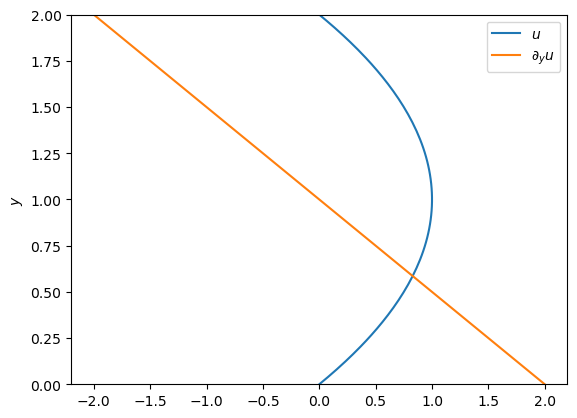

In [5]:
U  = field.Field(domain, name='U')
Uy = field.Field(domain, name='Uy')

U['g'] = y*(2-y)
U.differentiate('y',out=Uy)
U.set_scales(1)
Uy.set_scales(1)
plt.plot(U['g'].real,y,label=r'$u$')
plt.plot(Uy['g'].real,y,label=r'$\partial_y u$')
plt.ylabel(r'$y$')
plt.ylim([0,2])
plt.legend();
# plt.savefig("base_flow.png",dpi=150,transparent=True)

### Set up the direct and adjoint problems

In [6]:
%%time
problemDirect = de.EVP(domain, eigenvalue='omega',variables=['u','uy','v','vy','w','wy','p'])
problemDirect.parameters['Re']    = Re
problemDirect.parameters['alpha'] = alpha
problemDirect.parameters['beta']  = beta
problemDirect.parameters['U'] = U
problemDirect.parameters['Uy'] = Uy

problemDirect.add_equation("omega*u + 1j*alpha*u*U + v*Uy + 1j*alpha*p + 1./Re*((alpha**2+beta**2)*u - dy(uy)) = 0")
problemDirect.add_equation("omega*v + 1j*alpha*v*U +        dy(p)      + 1./Re*((alpha**2+beta**2)*v - dy(vy)) = 0")
problemDirect.add_equation("omega*w + 1j*alpha*w*U +        1j*beta*p  + 1./Re*((alpha**2+beta**2)*w - dy(wy)) = 0")
problemDirect.add_equation("1j*alpha*u + vy + 1j*beta*w = 0")

problemDirect.add_equation("dy(u) - uy = 0")
problemDirect.add_equation("dy(v) - vy = 0")
problemDirect.add_equation("dy(w) - wy = 0")

problemDirect.add_bc("left(u) = 0")
problemDirect.add_bc("right(u) = 0")
problemDirect.add_bc("left(v) = 0")
problemDirect.add_bc("right(v) = 0")
problemDirect.add_bc("left(w) = 0")
problemDirect.add_bc("right(w) = 0")

problemAdjoint = de.EVP(domain, eigenvalue='omega',variables=['u','uy','v','vy','w','wy','p'])
problemAdjoint.parameters['Re'] = Re
problemAdjoint.parameters['alpha'] = alpha
problemAdjoint.parameters['beta']  = beta

problemAdjoint.parameters['U'] = U
problemAdjoint.parameters['Uy'] = Uy

problemAdjoint.add_equation("omega*u - 1j*alpha*u*U -        1j*alpha*p + 1./Re*((alpha**2+beta**2)*u - dy(uy)) = 0")
problemAdjoint.add_equation("omega*v - 1j*alpha*v*U + u*Uy - dy(p)      + 1./Re*((alpha**2+beta**2)*v - dy(vy)) = 0")
problemAdjoint.add_equation("omega*w - 1j*alpha*w*U -        1j*beta*p  + 1./Re*((alpha**2+beta**2)*w - dy(wy)) = 0")
problemAdjoint.add_equation("-1j*alpha*u - vy - 1j*beta*w = 0")

problemAdjoint.add_equation("dy(u) - uy = 0")
problemAdjoint.add_equation("dy(v) - vy = 0")
problemAdjoint.add_equation("dy(w) - wy = 0")

problemAdjoint.add_bc("left(u) = 0")
problemAdjoint.add_bc("right(u) = 0")
problemAdjoint.add_bc("left(v) = 0")
problemAdjoint.add_bc("right(v) = 0")
problemAdjoint.add_bc("left(w) = 0")
problemAdjoint.add_bc("right(w) = 0")

2022-12-09 15:45:01,186 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-12-09 15:45:01,221 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
CPU times: user 61.5 ms, sys: 7.18 ms, total: 68.7 ms
Wall time: 72.1 ms


### Solve the eigenvalue problems

In [7]:
%%time
EP_direct = Eigenproblem(problemDirect)
EP_direct.solve(sparse=False)

EP_adjoint = Eigenproblem(problemAdjoint)
EP_adjoint.solve(sparse=False)

2022-12-09 15:45:01,268 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-12-09 15:45:42,889 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
CPU times: user 1min 20s, sys: 1.01 s, total: 1min 21s
Wall time: 1min 22s


### Plot the eigenvalues

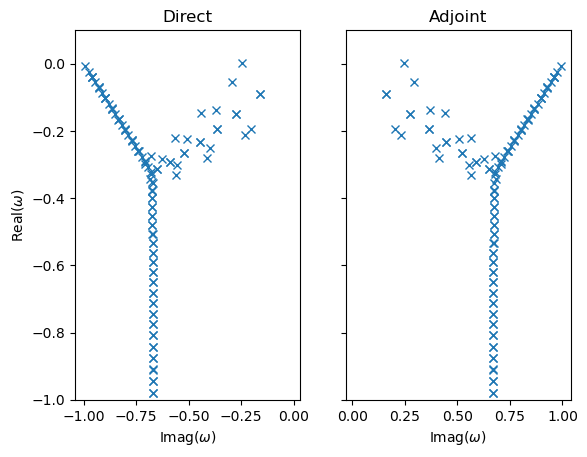

In [8]:
fig, ax = plt.subplots(1,2,sharey=True)

ax[0].plot(EP_direct.evalues.imag,EP_direct.evalues.real,'x')
ax[0].set_ylim([-1,0.1])
ax[0].set_xlabel(r'Imag($\omega$)')
ax[0].set_ylabel(r'Real($\omega$)')
ax[0].set_title(r'Direct')
ax[1].plot(EP_adjoint.evalues.imag,EP_adjoint.evalues.real,'x')
ax[1].set_ylim([-1,0.1])
ax[1].set_xlabel(r'Imag($\omega$)')
ax[1].set_title(r'Adjoint');
# plt.savefig("eigenvalues.png",dpi=150,transparent=True)

Note that as expected, the eigenvalues of the adjoint operator are exactly the complex conjugates of the eigenvalues of the direct operator.

### Find the most unstable-mode and its adjoint counterpart

In [9]:
idx = np.argmax(EP_direct.evalues.real)
most_unstable_direct = EP_direct.eigenmode(idx)

idx = np.argmax(EP_adjoint.evalues.real)
most_unstable_adjoint = EP_adjoint.eigenmode(idx)

### Normalise the direct mode such that $\langle \mathbf{u},\mathbf{u}\rangle=1$.

In [10]:
norm = (np.conj(most_unstable_direct['u'])*most_unstable_direct['u']+np.conj(most_unstable_direct['v'])*most_unstable_direct['v']+np.conj(most_unstable_direct['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
print('Original norm',norm)
most_unstable_direct['u']['g'] /= np.sqrt(norm)
most_unstable_direct['v']['g'] /= np.sqrt(norm)
most_unstable_direct['w']['g'] /= np.sqrt(norm)
norm = (np.conj(most_unstable_direct['u'])*most_unstable_direct['u']+np.conj(most_unstable_direct['v'])*most_unstable_direct['v']+np.conj(most_unstable_direct['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
print('New norm',norm)

Original norm (0.003981395539798955+0j)
New norm (1.0000000000000002+0j)


### Normalise the adjoint mode such that $\langle \mathbf{u}^\dagger,\mathbf{u}\rangle=1$.

In [11]:
norm = (np.conj(most_unstable_adjoint['u'])*most_unstable_direct['u']+np.conj(most_unstable_adjoint['v'])*most_unstable_direct['v']+np.conj(most_unstable_adjoint['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
print('Original norm',norm)
most_unstable_adjoint['u']['g'] /= np.conj(norm)
most_unstable_adjoint['v']['g'] /= np.conj(norm)
most_unstable_adjoint['w']['g'] /= np.conj(norm)
norm = norm = (np.conj(most_unstable_adjoint['u'])*most_unstable_direct['u']+np.conj(most_unstable_adjoint['v'])*most_unstable_direct['v']+np.conj(most_unstable_adjoint['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
print('New norm',norm)

Original norm (9.440544000307696e-05-0.005939182391868592j)
New norm (1.0000000000000007+4.347208880931189e-16j)


### Plot the direct and adjoint modes

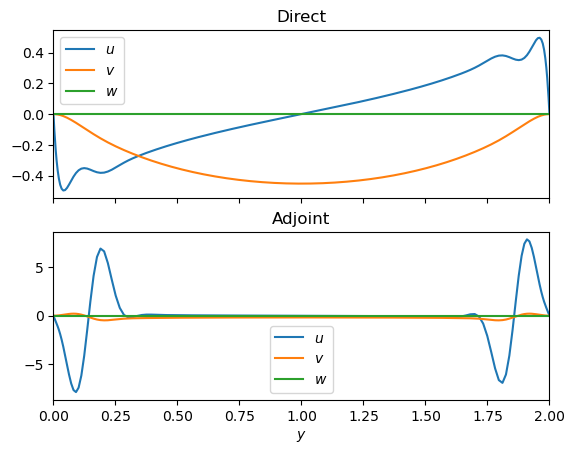

In [12]:
fig, ax = plt.subplots(2,1,sharex=True)

ax[0].plot(y,most_unstable_direct['u']['g'].real,label=r'$u$')
ax[0].plot(y,most_unstable_direct['v']['g'].real,label=r'$v$')
ax[0].plot(y,most_unstable_direct['w']['g'].real,label=r'$w$')
ax[0].legend()
ax[0].set_xlim([0,2])
ax[0].set_title('Direct')
ax[1].plot(y,most_unstable_adjoint['u']['g'].real,label=r'$u$')
ax[1].plot(y,most_unstable_adjoint['v']['g'].real,label=r'$v$')
ax[1].plot(y,most_unstable_adjoint['w']['g'].real,label=r'$w$')
ax[1].legend()
ax[1].set_xlim([0,2])
ax[1].set_title('Adjoint')
ax[1].set_xlabel(r'$y$');
# plt.savefig("eigenvectors.png",dpi=150,transparent=True)

It is clear that even though the eigenvalues of the two operators are the same, the eigenvectors are quite different. In terms of sensitivity, the adjoint shows us that perturbations near the wall are much more effective at changing the eigenvalue, even though the direct mode is large in the centre.

# Sensitivity analysis

With the direct and adjoint mode calculated, let us now use our adjoint formula $\delta \omega  = \langle \mathbf{u}^\dagger,\delta \mathcal{A}\mathbf{u}\rangle$ to assess how the eigenvalue will change if the Reynolds number is changed. The formula tells us that 
$$\frac{\partial\omega}{\partial Re}  = \langle \mathbf{u}^\dagger,\frac{\partial \mathcal{A}}{\partial Re}\mathbf{u}\rangle.$$ We already know $\mathbf{u}^\dagger$ and $\mathbf{u}$, so all that remains is to calculate the operator $\frac{\partial \mathcal{A}}{\partial Re}$, which is easily found via differentiation to be
$$ \frac{\partial \mathcal{A}}{\partial Re}=-\frac{1}{Re^2}\left(\partial_{yy}-\left(\alpha^2+\beta^2\right)\right).$$

We can now calculate this using Dedalus

### Define the Laplacian operator

In [13]:
def lap(u,v,w):
    uyy = de.operators.differentiate(u, y=2)
    vyy = de.operators.differentiate(v, y=2)
    wyy = de.operators.differentiate(w, y=2)
    u_lap = -(alpha**2+beta**2)*u + uyy
    v_lap = -(alpha**2+beta**2)*v + vyy
    w_lap = -(alpha**2+beta**2)*w + wyy
    return u_lap.evaluate(),v_lap.evaluate(),w_lap.evaluate()

### Apply the Laplacian operator to $\mathbf{u}$

In [14]:
u_lap, v_lap, w_lap = lap(most_unstable_direct['u'],most_unstable_direct['v'],most_unstable_direct['w'])

### Calculate the sensitivity with respect to the Reynolds number

In [15]:
# Sensitivity wrt Re
domdRe = (np.conj(most_unstable_adjoint['u'])*u_lap+np.conj(most_unstable_adjoint['v'])*v_lap+np.conj(most_unstable_adjoint['w'])*w_lap).evaluate().integrate()['g'][0]
domdRe *= -1./Re**2
print('dω/dRe =',domdRe)

dω/dRe = (7.793373241811189e-07+5.431301239086212e-06j)


The result shows us that increasing the Reynolds number will increase both the growth rate and frequency of the mode. Lets check by calculating the eigenvalue at $Re=8500$.

In [16]:
old_most_unstable = EP_direct.evalues[np.argmax(EP_direct.evalues.real)]
EP_direct.solve(sparse=True,target=-0.26j,N=10, parameters={'Re':8500})
new_most_unstable = EP_direct.evalues[np.argmax(EP_direct.evalues.real)]
print('At Re=8000, omega = ',old_most_unstable)
print('At Re=8500, omega = ',new_most_unstable)
print('Prediction using linear interpolation = ',old_most_unstable+500*domdRe)

At Re=8000, omega =  (0.002664410371118129-0.2470750601749862j)
At Re=8500, omega =  (0.003018756837360654-0.2444517399557504j)
Prediction using linear interpolation =  (0.0030540790332086887-0.2443594095554431j)


As we can see, the adjoint gives a reasonable prediction of the new eigenvalue. Now lets use this gradient information in a couple of different ways. 

## Interpolation

Firstly, we can calculate the maximum growth rate at a sparse range of Reynolds numbers. By also calculating the adjoint eigenvector at each of these Reynolds numbers we can additionally obtain the gradient, allowing us to interpolate between points using a cubic.

### Function to perform the cubic interpolation

In [17]:
def cubeFit(x1,x2,fx1,fx2,fx1d,fx2d):
    # Finds coefficients f(x) = Ax^3+Bx^2+Cx+D such that
    # f(x1)  = fx1
    # f(x2)  = fx2
    # f'(x1) = fx1d
    # f'(x2) = fx2d

    RHS = np.array([fx1,fx2,fx1d,fx2d]);
    row1 = np.array([x1**3, x1**2, x1, 1])
    row2 = np.array([x2**3, x2**2, x2, 1])
    row3 = np.array([3*x1**2, 2*x1, 1, 0])
    row4 = np.array([3*x2**2, 2*x2, 1, 0])
    LHS = np.vstack((row1,row2,row3,row4))
    ANS = np.linalg.solve(LHS,RHS)
    A = ANS[0]
    B = ANS[1]
    C = ANS[2]
    D = ANS[3]
    return A,B,C,D

### Calculate the maximum growth rate and its gradient at a range of Reynolds numbers

In [18]:
%%time
Reynolds = np.linspace(500,12000,10)
growths = []
gradients = []
for Re_v in Reynolds:
    print('Solving for Re = {0:8.02f}'.format(Re_v))
    EP_direct.solve(sparse=True,target=-0.26j,N=20, parameters={'Re':Re_v})
    max_growth = EP_direct.evalues[np.argmax(EP_direct.evalues.real)].real
    growths.append(max_growth)
    
    EP_adjoint.solve(sparse=True,target=0.26j,N=20, parameters={'Re':Re_v})
    
    idx = np.argmax(EP_direct.evalues.real)
    most_unstable_direct = EP_direct.eigenmode(idx)

    idx = np.argmax(EP_adjoint.evalues.real)
    most_unstable_adjoint = EP_adjoint.eigenmode(idx)
    
    # Normalise
    norm = (np.conj(most_unstable_adjoint['u'])*most_unstable_direct['u']+np.conj(most_unstable_adjoint['v'])*most_unstable_direct['v']+np.conj(most_unstable_adjoint['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]
    most_unstable_adjoint['u']['g'] /= np.conj(norm)
    most_unstable_adjoint['v']['g'] /= np.conj(norm)
    most_unstable_adjoint['w']['g'] /= np.conj(norm)
    norm = (np.conj(most_unstable_adjoint['u'])*most_unstable_direct['u']+np.conj(most_unstable_adjoint['v'])*most_unstable_direct['v']+np.conj(most_unstable_adjoint['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]

    u_lap, v_lap, w_lap = lap(most_unstable_direct['u'],most_unstable_direct['v'],most_unstable_direct['w'])
    domdRe = (np.conj(most_unstable_adjoint['u'])*u_lap+np.conj(most_unstable_adjoint['v'])*v_lap+np.conj(most_unstable_adjoint['w'])*w_lap).evaluate().integrate()['g'][0]
    domdRe *= -1./Re_v**2
    
    gradients.append(domdRe.real)

Solving for Re =   500.00
Solving for Re =  1777.78
Solving for Re =  3055.56
Solving for Re =  4333.33
Solving for Re =  5611.11
Solving for Re =  6888.89
Solving for Re =  8166.67
Solving for Re =  9444.44
Solving for Re = 10722.22
Solving for Re = 12000.00
CPU times: user 2.39 s, sys: 57.3 ms, total: 2.44 s
Wall time: 2.48 s


### Plot the cubic interpolation

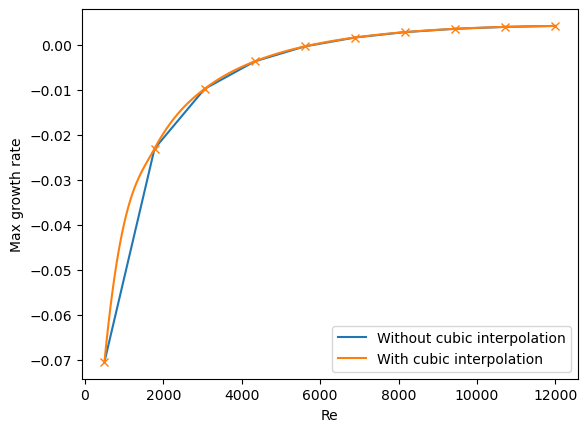

In [19]:
plt.plot(Reynolds,growths,'C0')
for i in range(len(growths)-1):
    A,B,C,D = cubeFit(Reynolds[i],Reynolds[i+1],growths[i],growths[i+1],gradients[i],gradients[i+1])
    x = np.linspace(Reynolds[i],Reynolds[i+1],100)
    f = A*x**3+B*x**2+C*x+D
    plt.plot(x,f,'C1')
    plt.plot(Reynolds[i],growths[i],'C1x')
    plt.xlabel(r'Re')
    plt.ylabel(r'Max growth rate')
plt.plot(Reynolds[-1],growths[-1],'C1x')
plt.legend(['Without cubic interpolation','With cubic interpolation']);
# plt.savefig("growth_rates.png",dpi=150,transparent=True)

We see that the cubic interpolation gives a much smoother growth-rate curve, especially for lower Reynolds numbers where the growth-rate is changing quickly. This shows how adjoints can be used for *interpolation*, and also how they give us information that can be used to more carefully place our simulations, e.g. perform more simulations where the gradient is larger.

## Critical-parameter search

Secondly, we can also use the gradient information to help find a critical parameter via gradient-based optimisation. To do this we can use $scipy.optimize.minimize$, providing the cost function as $\mathcal{J}=\textrm{Real}(\omega)^2$. This is minimised at the critcal Reynolds number $Re_c$. The gradient is then $$\frac{\partial\mathcal{J}}{\partial Re}=2\textrm{Real}(\omega)\textrm{Real}\left(\frac{\partial \omega}{\partial Re}\right).$$ The L-BFGS algorithm can use the cost and the gradient to find the critical parameter.

## Define our cost-gradient function

In [20]:
def cost_grad(Re_v):
    # Takes the Reynolds number and returns the cost and the gradient
    EP_direct.solve(sparse=True,target=-0.26j,N=20, parameters={'Re':Re_v[0]})
    max_growth = EP_direct.evalues[np.argmax(EP_direct.evalues.real)].real
    growths.append(max_growth)
    
    EP_adjoint.solve(sparse=True,target=0.26j,N=20, parameters={'Re':Re_v[0]})
    
    idx = np.argmax(EP_direct.evalues.real)
    most_unstable_direct = EP_direct.eigenmode(idx)
    cost = EP_direct.evalues.real[idx]**2
    growth = EP_direct.evalues.real[idx]
    idx = np.argmax(EP_adjoint.evalues.real)
    most_unstable_adjoint = EP_adjoint.eigenmode(idx)
    
    # Normalise
    norm = (np.conj(most_unstable_adjoint['u'])*most_unstable_direct['u']+np.conj(most_unstable_adjoint['v'])*most_unstable_direct['v']+np.conj(most_unstable_adjoint['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]

    most_unstable_adjoint['u']['g'] /= np.conj(norm)
    most_unstable_adjoint['v']['g'] /= np.conj(norm)
    most_unstable_adjoint['w']['g'] /= np.conj(norm)
    norm = (np.conj(most_unstable_adjoint['u'])*most_unstable_direct['u']+np.conj(most_unstable_adjoint['v'])*most_unstable_direct['v']+np.conj(most_unstable_adjoint['w'])*most_unstable_direct['w']).evaluate().integrate()['g'][0]

    u_lap, v_lap, w_lap = lap(most_unstable_direct['u'],most_unstable_direct['v'],most_unstable_direct['w'])
    domdRe = (np.conj(most_unstable_adjoint['u'])*u_lap+np.conj(most_unstable_adjoint['v'])*v_lap+np.conj(most_unstable_adjoint['w'])*w_lap).evaluate().integrate()['g'][0]
    domdRe *= -1./(Re_v[0]**2)
    gradient = 2*growth*domdRe.real
    print('{0:6.01f}  {1:5.02e}  {2:5.02e}'.format(Re_v[0],cost,gradient))
    
    return cost, np.array(gradient)

### Perform the optimisation

In [21]:
import scipy
from scipy.optimize import minimize

In [22]:
%%time
print('Re      cost      gradient')
sol = scipy.optimize.minimize(cost_grad, x0 = np.array(2000.0),jac=True,method='L-BFGS-B',tol=1e-14)
print('Re_c = {0:6.01f}'.format(sol.x[0]))
print('Number of function evaluations =',sol.nfev)

Re      cost      gradient
2000.0  3.92e-04  -5.34e-07
2001.0  3.91e-04  -5.33e-07
2005.0  3.89e-04  -5.30e-07
2021.0  3.81e-04  -5.18e-07
2085.0  3.49e-04  -4.71e-07
2727.7  1.49e-04  -1.97e-07
3187.9  8.05e-05  -1.10e-07
3768.9  3.51e-05  -5.31e-08
4313.7  1.43e-05  -2.60e-08
4837.4  4.74e-06  -1.18e-08
5274.4  1.20e-06  -4.94e-09
5586.9  1.87e-07  -1.72e-09
5753.2  1.28e-08  -4.19e-10
5807.0  2.02e-10  -5.17e-11
5814.5  2.67e-13  -1.87e-12
5814.8  5.90e-18  -8.80e-15
Re_c = 5814.8
Number of function evaluations = 16
CPU times: user 3.97 s, sys: 61.7 ms, total: 4.03 s
Wall time: 4.04 s


The critical Reynolds number for $\alpha=1$ and $\beta=0$, $Re_c \approx 5814.8$, is obtained using 16 eigenvalue solves.